In [86]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.draw import line

spacing = 2
cutoff = 2.0

def validEdges(arr, y, x):
    edges = []
    if arr[y+spacing][x]:
        edges.append((y+spacing, x))
    if arr[y-spacing][x]:
        edges.append((y-spacing, x))
    if arr[y][x+spacing]:
        edges.append((y, x+spacing))
    if arr[y][x-spacing]:
        edges.append((y, x-spacing))
    return edges

def drawLines(arr, y, x):
    tile = np.full(arr.shape, 0)
    populatedEdges = validEdges(arr, y, x)
    
    if len(populatedEdges) == 2:
        tile[line(populatedEdges[0][0], populatedEdges[0][1], populatedEdges[1][0], populatedEdges[1][1])] = 1
    elif len(populatedEdges) > 2:
        for edge in populatedEdges:
            tile[line(edge[0], edge[1], y, x)] = 1
        
    return tile

def tileCoord(x):
    return 2*spacing*x+spacing

In [87]:
with rasterio.open('data/convolvedPopulation.tif') as pop:
    popCrs = pop.crs
    popTransform = pop.transform
    
    array = pop.read(1)
    popHeight, popWidth = array.shape

In [88]:
halfRows = (popHeight+1) // spacing
halfColumns = (popWidth+1) // spacing
sampleArray = np.full((popHeight, popWidth), False, dtype = bool)

for i in range(halfRows):
    if i%2 == 0:
        for j in range(halfColumns // 2):
            if array[spacing*i][2*spacing*j+spacing] >= cutoff:
                sampleArray[spacing*i][2*spacing*j+spacing] = True
    else:
        for j in range(halfColumns - (halfColumns // 2)):
            if array[spacing*i][2*spacing*j] >= cutoff:
                sampleArray[spacing*i][2*spacing*j] = True

In [89]:
lineArray = np.full((popHeight, popWidth), 0.0)

for i in range(halfRows-(halfRows // 2)-1):
    for j in range(halfColumns-(halfColumns // 2)-1):
        lineArray += drawLines(sampleArray, tileCoord(i), tileCoord(j))

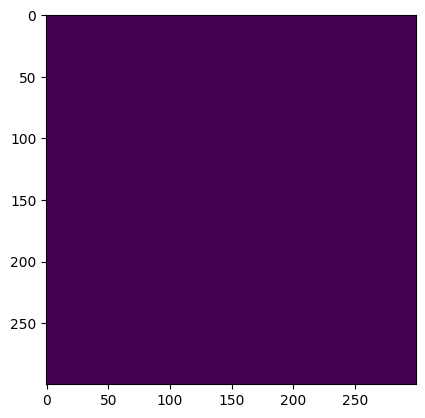

In [90]:
plt.imshow(lineArray)

In [91]:
lineDtype = lineArray.dtype

with rasterio.open(
    'data/lines.tif', 'w',
    driver = 'GTiff',
    height = popHeight,
    width = popWidth,
    count = 1,
    crs = popCrs,
    transform = popTransform,
    dtype = lineDtype
) as lines:
    lines.write(lineArray, 1)